# Set up the matrix

In [26]:
import sys
sys.executable

'C:\\Users\\KarlKristian\\Anaconda3\\envs\\numfys\\python.exe'

In [27]:
%load_ext autoreload
%autoreload 2

In [29]:
from walker import *
from grid import *
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.sparse as sp
import scipy.sparse.linalg as lg
from numba import jit
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from dask import delayed, compute
import matplotlib.path as mplpath

In [30]:
g = 5 # recursion depth
pts = 0 # points between each corner of the fractal
%time position_dict = koch_walker(depth=g, points_between=pts)
save_grid(position_dict, g, pts)

Wall time: 39.7 s


Load grid

In [31]:
%time position_dict = load_grid(5, 0)

Wall time: 55.8 ms


In [32]:
pos_list = np.array(list(position_dict))

In [33]:
max_idx = normalize(pos_list)
%time normalized_dict = {tuple(p):True for p in pos_list}
max_idx

Wall time: 202 ms


1706

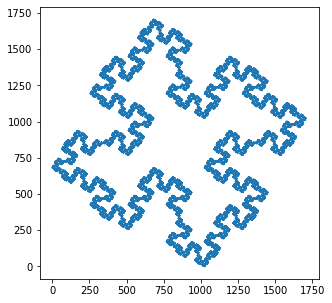

In [38]:
fig = plt.figure(figsize=(5,5))
plt.plot(*zip(*pos_list))

## point inside?
---
### matplotlib.path

In [8]:
path=mplpath.Path(pos_list)

In [43]:
points = np.random.randint(0, high =max_idx, size = (10000,2))

In [44]:
points.shape

(10000, 2)

In [11]:
%time path.contains_points(points)

Wall time: 3.86 s


array([False,  True, False, ...,  True, False,  True])

In [12]:
fractal = np.zeros((max_idx,max_idx))

In [40]:
all_points = np.array([(i,j) for i in range(max_idx) for j in range(max_idx)])
all_points.shape

(2910436, 2)

In [15]:
all_points[:5]

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [0, 4]])

In [14]:
all_points.shape

(2903616, 2)

In [ ]:
%time contains = path.contains_points(all_points)
%time fractal[contains] += 1

In [ ]:
fig = plt.figure(figsize = (10,10))
plt.imshow(fractal)

### shapely

In [49]:
%time polygon = Polygon(pos_list)
%time contains = [Point(point).within(polygon) for point in points[0:200]]

#contains = [Polygon.contains(point) for point in testpoints]

Wall time: 1.99 ms
Wall time: 2.69 s


### Ray tracing

In [52]:
def ray_tracing(point, pos_dict, max_idx, inside_dict):
    point=  tuple(point)
    pos_list = []
    inside_list = []
    if pos_dict.get(tuple(point), False):
        return True
    elif point in inside_dict:
        return inside_dict.get(point)
            
    sign = 1
    x0, y0 = point
    if x0 < max_idx//2:
        if y0 < x0:
            sign = -1
            idx = 1# direction: substract from y
        else:
            sign = -1
            idx = 0
            # direction substract from x
    else:
        if y0 > x0:
            idx=1
            # add to y
        else:
            idx = 0
            # add to x
    p = list(point)
    inside = False
    
    while p[idx] > 0 & p[idx] < max_idx:
        temp = p[idx] + sign
        p[idx] = temp
        po = tuple(p)
        if pos_dict.get(po, False):
            inside = not inside
            inside_list = [not i for i in inside_list]
        elif po in inside_dict:
            val = inside_dict.get(po)
            inside_dict.update({point: val})
            return val
        pos_list.append(po)
        inside_list.append(inside)
    temp_dict = dict(zip(pos_list, inside_list))
    inside_dict.update(temp_dict)
    return inside

In [42]:
inside_dict = {}

In [ ]:
%time c = [ray_tracing(p, normalized_dict, max_idx, inside_dict) for p in all_points]

In [74]:
fast_ray_tracing = jit(ray_tracing) # hvorfor er den så treg?

In [25]:
%time contains_ray = np.array([ray_tracing(point, ndict, max_idx) for point in pos_list[0:10000]])
#%time [fast_ray_tracing(point, position_dict, max_idx) for point in pos_list[0:10]]

NameError: name 'np' is not defined

In [76]:
%time contains_ray = np.array([fast_ray_tracing(point, ndict, max_idx) for point in pos_list[0:10000]])

Wall time: 1.43 s


In [78]:
%%time
res = []
for point in pos_list[0:100]:
    a = delayed(ray_tracing)(point, position_dict, max_idx)
    res.append(a)
results =compute(res)

Wall time: 3min 3s


In [ ]:
res[0].visualize()

In [17]:
a = [(i,j) for i in range(10) for j in range(10)]
b = [i % 2 ==0 for i in range(100)]

In [22]:
test_di = dict(zip(a, b))

In [23]:
test_di

{(0, 0): True,
 (0, 1): False,
 (0, 2): True,
 (0, 3): False,
 (0, 4): True,
 (0, 5): False,
 (0, 6): True,
 (0, 7): False,
 (0, 8): True,
 (0, 9): False,
 (1, 0): True,
 (1, 1): False,
 (1, 2): True,
 (1, 3): False,
 (1, 4): True,
 (1, 5): False,
 (1, 6): True,
 (1, 7): False,
 (1, 8): True,
 (1, 9): False,
 (2, 0): True,
 (2, 1): False,
 (2, 2): True,
 (2, 3): False,
 (2, 4): True,
 (2, 5): False,
 (2, 6): True,
 (2, 7): False,
 (2, 8): True,
 (2, 9): False,
 (3, 0): True,
 (3, 1): False,
 (3, 2): True,
 (3, 3): False,
 (3, 4): True,
 (3, 5): False,
 (3, 6): True,
 (3, 7): False,
 (3, 8): True,
 (3, 9): False,
 (4, 0): True,
 (4, 1): False,
 (4, 2): True,
 (4, 3): False,
 (4, 4): True,
 (4, 5): False,
 (4, 6): True,
 (4, 7): False,
 (4, 8): True,
 (4, 9): False,
 (5, 0): True,
 (5, 1): False,
 (5, 2): True,
 (5, 3): False,
 (5, 4): True,
 (5, 5): False,
 (5, 6): True,
 (5, 7): False,
 (5, 8): True,
 (5, 9): False,
 (6, 0): True,
 (6, 1): False,
 (6, 2): True,
 (6, 3): False,
 (6, 4):